# 🍔👁 Food Vision Big™


We're going to be building Food Vision Big™, using all of the data from the Food101 dataset.

Yep. All 75,750 training images and 25,250 testing images.

And guess what...

This time **we've got the goal of beating [DeepFood](https://www.researchgate.net/publication/304163308_DeepFood_Deep_Learning-Based_Food_Image_Recognition_for_Computer-Aided_Dietary_Assessment)**, a 2016 paper which used a Convolutional Neural Network trained for 2-3 days to achieve 77.4% top-1 accuracy.


|  | 🍔👁 Food Vision Big™ |
|-----|-----|
| Dataset source | TensorFlow Datasets |
| Train data | 75,750 images |
| Test data | 25,250 images |  
| Mixed precision | Yes |
| Data loading | Performanant tf.data API |
| Target results | 77.4% top-1 accuracy (beat [DeepFood paper](https://arxiv.org/abs/1606.05675)) | 





In [46]:
# Need to install tensorflow nightly for this project
!pip install tf-nightly

In [47]:
import tensorflow as tf

In [48]:
# Check GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-64483064-9406-9d3b-0067-429b6f9c6326)


In [49]:
# Get helper functions file
import os

if not os.path.exists("helper_functions.py"):
    !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
else:
    print("[INFO] 'helper_functions.py' already exists, skipping download.")

[INFO] 'helper_functions.py' already exists, skipping download.


In [50]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-64483064-9406-9d3b-0067-429b6f9c6326)


In [51]:
# Import series of helper functions for the notebook (we've created/used these in previous notebooks)
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

# Getting the data ready

Using tensorflow datasets

In [52]:
# Tensorflow datasets
import tensorflow_datasets as tfds

In [53]:
# Get all available datasets in tds
dataset_list = tfds.list_builders()
print('food101' in dataset_list)

True


In [54]:
(train_data, test_data), ds_info = tfds.load('food101',
                                             split=['train', 'validation'],
                                             as_supervised=True,
                                             with_info=True,
                                             shuffle_files=True
                                             )

In [55]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [56]:
class_names = ds_info.features['label'].names

In [57]:
train_one_sample = train_data.take(1)

In [58]:
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [59]:
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class: {class_names[label]}
  """)


  Image shape: (512, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class: chocolate_cake
  


In [60]:
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

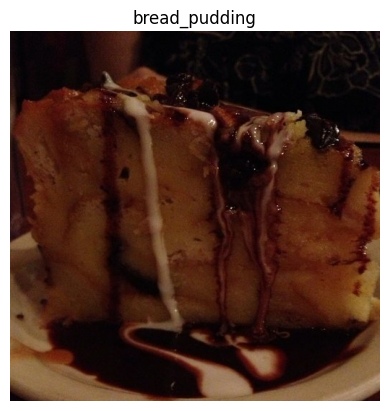

Shape: (512, 512, 3)


In [61]:
import matplotlib.pyplot as plt
(take_sample,) = train_data.take(1)
image, label = take_sample
plt.title(class_names[label])
plt.imshow(image)
plt.axis('off')
plt.show();
print(f"Shape: {image.shape}")

## Preprocessing the image

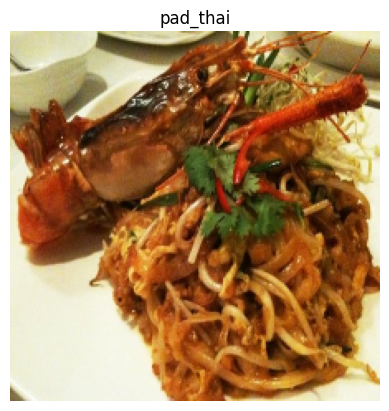

Shape: (224, 224, 3)


In [62]:
import matplotlib.pyplot as plt
(take_sample,) = train_data.take(1)
image, label = take_sample
plt.title(class_names[label])
preprocessed_image = tf.cast(image, tf.float32)* (1. / 255) # Normalize
preprocessed_image = tf.image.resize(preprocessed_image, (224,224)) # Resizing
plt.imshow(preprocessed_image)
plt.axis('off')
plt.show();
print(f"Shape: {preprocessed_image.shape}")

In [63]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
    """
    Converts image datatype from 'uint8' -> 'float32' and reshapes image to
    [img_shape, img_shape, color_channels]
    """
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, size=(img_shape, img_shape))
    return image, label

In [64]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_image.dtype}")

Image before preprocessing:
 [[[230 229 183]
  [231 230 184]
  [232 231 183]
  ...
  [232 233 202]
  [229 234 204]
  [229 236 205]]

 [[228 227 179]
  [227 226 178]
  [226 226 176]
  ...
  [234 235 204]
  [232 237 207]
  [234 241 210]]]...,
Shape: (384, 512, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[229.46939 228.46939 181.7551 ]
  [229.59184 228.94897 180.2347 ]
  [224.14796 224.14796 171.71939]
  ...
  [238.21933 231.07143 200.37251]
  [237.02545 233.38266 204.23978]
  [230.32655 236.04091 205.68373]]

 [[228.80103 228.87245 174.58673]
  [225.95409 225.95918 173.80103]
  [226.64795 226.64795 174.21939]
  ...
  [238.41322 232.41322 199.95409]
  [235.8571  233.14287 202.07143]
  [233.04602 238.76038 206.4032 ]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


In [65]:
def create_dataset(dataset):
  dataset = dataset.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE) # Utilize all CPU
  dataset = dataset.shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
  return dataset

In [66]:
train_data = create_dataset(train_data)
test_data = create_dataset(test_data)

In [67]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

# Callbacks

In [68]:
# Tensorboard callbacks
from helper_functions import create_tensorboard_callback

# Model Checkpoint
checkpoint_path = "model_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor='val_accuracy',
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0)

# Modelling and Setting up mixed precision

In [69]:
from tensorflow.keras import mixed_precision

mixed_precision.set_global_policy(policy='mixed_float16')

In [70]:
from tensorflow.keras import layers

inputs = layers.Input(shape=(224, 224, 3), name='input_layer')

base_model = tf.keras.applications.efficientnet.EfficientNetB2(include_top=False)
base_model.trainable = False

x = base_model(inputs)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)

outputs = layers.Activation('softmax', dtype=tf.float32, name='softmax_float32')(x)

model = tf.keras.Model(inputs, outputs, name='efficientb2')
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [71]:
model.summary()

Model: "efficientb2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb2 (Functional  (None, None, None, 1408   7768569   
 )                           )                                   
                                                                 
 global_average_pooling2d_1  (None, 1408)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_1 (Dense)             (None, 101)               142309    
                                                                 
 softmax_float32 (Activatio  (None, 101)               0         
 n)                                                              
                                                       

In [72]:
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb2 False float32 <Policy "mixed_float16">
global_average_pooling2d_1 True float32 <Policy "mixed_float16">
dense_1 True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [73]:
for layer in model.layers[1].layers[:5]:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

for _ in range(3):
  print('.')

for layer in model.layers[1].layers[-5:]:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_2 False float32 <Policy "float32">
rescaling_2 False float32 <Policy "mixed_float16">
normalization_1 False float32 <Policy "mixed_float16">
rescaling_3 False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
.
.
.
block7b_drop False float32 <Policy "mixed_float16">
block7b_add False float32 <Policy "mixed_float16">
top_conv False float32 <Policy "mixed_float16">
top_bn False float32 <Policy "mixed_float16">
top_activation False float32 <Policy "mixed_float16">


In [74]:
initial_epochs = 5

In [75]:
# Turn off all warnings except for errors
tf.get_logger().setLevel('ERROR')

history_101_food_classes_feature_extract = model.fit(train_data,
                                                     epochs=initial_epochs,
                                                     steps_per_epoch=len(train_data),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     callbacks=[create_tensorboard_callback("training_logs",
                                                                                            "efficientnetb2_101_classes_all_data_feature_extract"),
                                                                model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb2_101_classes_all_data_feature_extract/20230815-072248
Epoch 1/5
2368/2368 [==============================] - 261s 99ms/step - loss: 1.7949 - accuracy: 0.5590 - val_loss: 1.1651 - val_accuracy: 0.6947
Epoch 2/5
2368/2368 [==============================] - 206s 86ms/step - loss: 1.3016 - accuracy: 0.6602 - val_loss: 1.0603 - val_accuracy: 0.7161
Epoch 3/5
2368/2368 [==============================] - 209s 87ms/step - loss: 1.1694 - accuracy: 0.6933 - val_loss: 1.0302 - val_accuracy: 0.7188
Epoch 4/5
2368/2368 [==============================] - 205s 86ms/step - loss: 1.0848 - accuracy: 0.7126 - val_loss: 1.0063 - val_accuracy: 0.7238
Epoch 5/5
2368/2368 [==============================] - 206s 86ms/step - loss: 1.0178 - accuracy: 0.7272 - val_loss: 1.0086 - val_accuracy: 0.7188


In [76]:
# Evaluate model (unsaved version) on whole test dataset
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 [==============================] - 63s 78ms/step - loss: 0.9988 - accuracy: 0.7253


[0.9988078474998474, 0.7253465056419373]

# Fine-Tuning EfficientNet

In [78]:
base_model.trainable = True

# Freeze all layers except for the
for layer in base_model.layers[:-300]:
  layer.trainable = False

# Recompile the model (always recompile after any adjustments to a model)
model.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # lr is 10x lower than before for fine-tuning
                metrics=["accuracy"])

In [79]:
for layer in model.layers[1].layers[:5]:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

for _ in range(3):
  print('.')

for layer in model.layers[1].layers[-5:]:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_2 False float32 <Policy "float32">
rescaling_2 False float32 <Policy "mixed_float16">
normalization_1 False float32 <Policy "mixed_float16">
rescaling_3 False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
.
.
.
block7b_drop True float32 <Policy "mixed_float16">
block7b_add True float32 <Policy "mixed_float16">
top_conv True float32 <Policy "mixed_float16">
top_bn True float32 <Policy "mixed_float16">
top_activation True float32 <Policy "mixed_float16">


In [80]:
model.summary()

Model: "efficientb2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb2 (Functional  (None, None, None, 1408   7768569   
 )                           )                                   
                                                                 
 global_average_pooling2d_1  (None, 1408)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_1 (Dense)             (None, 101)               142309    
                                                                 
 softmax_float32 (Activatio  (None, 101)               0         
 n)                                                              
                                                       

In [81]:
fine_tune_epoch = initial_epochs + 3

In [82]:
# Refit the model (same as model except with more trainable layers)
fine_tuned_efficientb2 = model.fit(train_data,
                                  epochs=fine_tune_epoch,
                                  initial_epoch=history_101_food_classes_feature_extract.epoch[-1],
                                  validation_data=test_data,
                                  validation_steps=int(0.15 * len(test_data)))

Epoch 5/8
2368/2368 [==============================] - 546s 206ms/step - loss: 1.1932 - accuracy: 0.6851 - val_loss: 0.7021 - val_accuracy: 0.8048
Epoch 6/8
2368/2368 [==============================] - 491s 206ms/step - loss: 0.6543 - accuracy: 0.8191 - val_loss: 0.6571 - val_accuracy: 0.8149
Epoch 7/8
2368/2368 [==============================] - 499s 209ms/step - loss: 0.4126 - accuracy: 0.8844 - val_loss: 0.6459 - val_accuracy: 0.8231
Epoch 8/8
2368/2368 [==============================] - 498s 209ms/step - loss: 0.2553 - accuracy: 0.9282 - val_loss: 0.6369 - val_accuracy: 0.8340


In [85]:
fine_tuned_efficientb2_result = model.evaluate(test_data)
fine_tuned_efficientb2_result

790/790 [==============================] - 67s 80ms/step - loss: 0.6686 - accuracy: 0.8228


[0.668639063835144, 0.8227722644805908]

## Ploting the loss/acc curve of fine-tuning

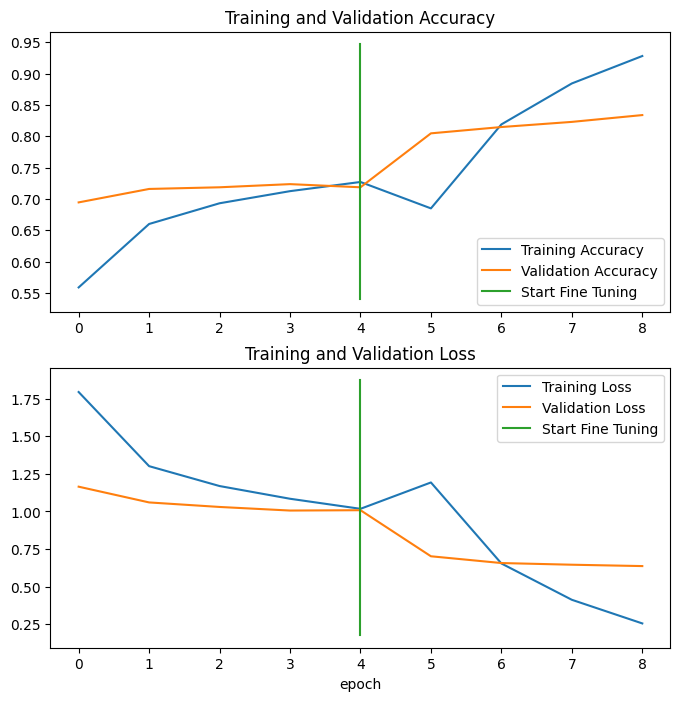

In [86]:
compare_historys(history_101_food_classes_feature_extract, fine_tuned_efficientb2)

# Saving/loading models

In [92]:
model.save('fine-tuned-effb7.keras')

In [93]:
loaded_model = tf.keras.models.load_model('fine-tuned-effb7.keras')

In [94]:
loaded_model_result =  loaded_model.evaluate(test_data)
loaded_model_result

790/790 [==============================] - 75s 87ms/step - loss: 0.6686 - accuracy: 0.8228


[0.6686384677886963, 0.8227722644805908]